In [1]:
import numpy as np
import pandas as pd
import session_info

# Plots
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from mapie.regression import MapieTimeSeriesRegressor

# Warnings configuration
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

In [2]:
# Leitura dos Dados

df_bf = pd.read_excel('Botafogo-2015-2023_Semanal_Dengue.xlsx')
df_cd = pd.read_excel('CidadeDeDeus-2015-2023_Semanal_Dengue.xlsx')
df_cp = pd.read_excel('Copacabana-2015-2023_Semanal_Dengue.xlsx')
df_ed = pd.read_excel('EngenhoDeDentro-2015-2023_Semanal_Dengue.xlsx')
df_ip = pd.read_excel('Ipanema-2015-2023_Semanal_Dengue.xlsx')
df_lj = pd.read_excel('Laranjeiras-2015-2023_Semanal_Dengue.xlsx')
df_mc = pd.read_excel('Maracana-2015-2023_Semanal_Dengue.xlsx')
df_rc = pd.read_excel('Rocinha-2015-2023_Semanal_Dengue.xlsx')
df_vm = pd.read_excel('VilaMilitar-2015-2023_Semanal_Dengue.xlsx')
df_rl = pd.read_excel('Realengo-2015-2023_Semanal_Dengue.xlsx')

In [3]:
# Definir a coluna de datas como índice e garantir o tipo datetime
def prepare_dataframe(df):
    df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
    df.set_index('data', inplace=True)
    return df

In [4]:
# Concatenação dos dados

dataframes = [prepare_dataframe(df) for df in [df_bf, df_cd, df_cp, df_ed, df_ip, df_lj, df_mc, df_rc, df_vm, df_rl]]
data = pd.concat(dataframes)

In [5]:
# OneHotEncoder na coluna Bairro
data = pd.get_dummies(data, columns=['bairro'])

In [6]:
# Variáveis Exógenas
exg = ['chuva', 'temperaturaMedia', 'temperaturaMaxima','temperaturaMinima', 'direcaoVento',
       'velocidadeVento', 'pressaoAtmosferica', 'semana','bairro_Botafogo',
       'bairro_Cidade de Deus', 'bairro_Copacabana',
       'bairro_Engenho de Dentro', 'bairro_Ipanema', 'bairro_Laranjeiras',
       'bairro_Maracana', 'bairro_Realengo', 'bairro_Rocinha',
       'bairro_Vila Militar']

In [7]:
data.sort_index(inplace=True)

# Manter uma cópia dos dados com índice de datas
data_with_dates = data.copy()

# Resetar o índice para a previsão autorregressiva
data.reset_index(drop=True, inplace=True)

In [8]:
# Split dos dados - train-test
steps = 1050
data_train = data[:-steps]
data_test  = data[-steps:]

data_train_dates = data_with_dates.iloc[:-steps]
data_test_dates  = data_with_dates.iloc[-steps:]

print(f"Train dates : {data_train_dates.index.min()} --- {data_train_dates.index.max()}  (n={len(data_train_dates)})")
print(f"Test dates  : {data_test_dates.index.min()} --- {data_test_dates.index.max()}  (n={len(data_test_dates)})")

Train dates : 2015-01-04 00:00:00 --- 2021-12-26 00:00:00  (n=3650)
Test dates  : 2022-01-02 00:00:00 --- 2023-12-31 00:00:00  (n=1050)


# DENGUE E CHIKUNGUNYA

## Previsão Autorregressiva

In [9]:
# Previsão Autorregressiva
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 80
             )

forecaster.fit(y=data_train['dengueChikungunya'], exog=data_train[exg])

predictions = forecaster.predict(steps=steps, exog=data_test[exg])

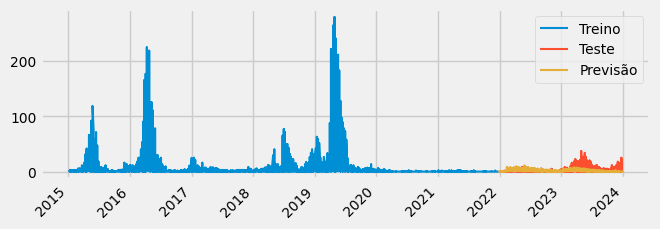

In [10]:
# Plot
fig, ax = plt.subplots(figsize=(7, 2.5))

# Plotting using the dataframe that retains the date index
data_train_dates['dengueChikungunya'].plot(ax=ax, label='Treino')
data_test_dates['dengueChikungunya'].plot(ax=ax, label='Teste')
predictions.index = data_test_dates.index  # Align predictions with test dates
predictions.plot(ax=ax, label='Previsão')

# Formatting the x-axis to show dates
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.set_xlabel('')  # This removes the "data" label
ax.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.show()


In [11]:
# Test error
error_mse = mean_squared_error(
                y_true = data_test['dengueChikungunya'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 14.139712952380952


In [12]:
predictions_interval = forecaster.predict_interval(
                    steps =-087641           = steps,
                    interval = [5, 95],
                    n_boot   = 500,
                    exog=data_test[exg]
              )

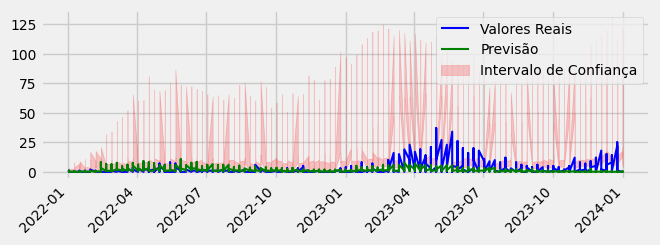

In [13]:
predictions.index = data_test_dates.index
predictions_interval.index = data_test_dates.index

fig, ax = plt.subplots(figsize=(7, 2.5))
data_test_dates['dengueChikungunya'].plot(ax=ax, label='Valores Reais', color='blue')
predictions.plot(ax=ax, label='Previsão', color='green')
ax.fill_between(
    predictions_interval.index,
    np.maximum(predictions_interval['lower_bound'], 0),
    predictions_interval['upper_bound'],
    color = 'red',
    alpha = 0.2,
    label='Intervalo de Confiança'
)

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.xticks(rotation=45)

ax.set_xlabel('')

ax.legend()
plt.show()


## MAPIE

In [14]:
# Inicialização MAPIE TimeSeriesRegressor
mapie_ts = MapieTimeSeriesRegressor(estimator=forecaster.regressor, method="enbpi")

In [15]:
# Fit MAPIE para train
mapie_ts.fit(data_train_dates[exg], data_train_dates['dengueChikungunya'])

MapieTimeSeriesRegressor(estimator=RandomForestRegressor(random_state=123))

In [16]:
# Predições com o intervalo
predictions_mapie, intervals = mapie_ts.predict(data_test_dates[exg], alpha=0.1)

In [17]:
# Certificando os intervalos com os formatos corretos
intervals = np.squeeze(np.asarray(intervals))

# Check the shape of intervals
print("Shape of intervals:", intervals.shape)

Shape of intervals: (1050, 2)


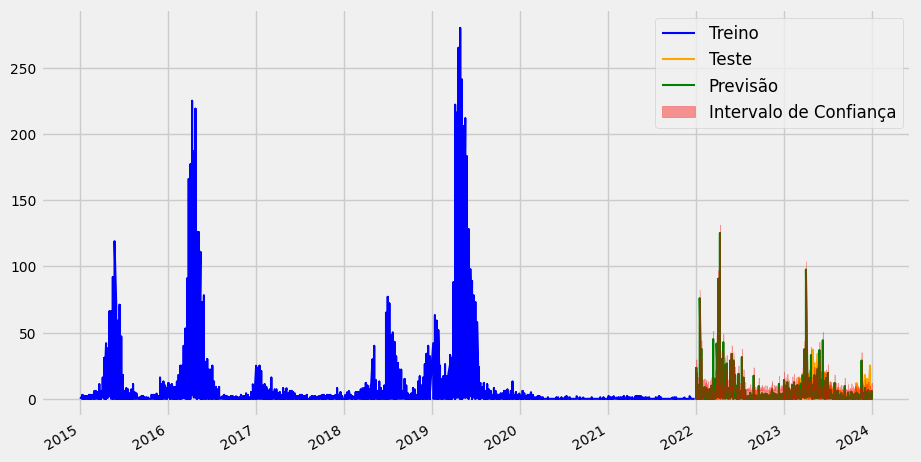

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

data_train_dates['dengueChikungunya'].plot(ax=ax, label='Treino', color='blue', zorder=1)
data_test_dates['dengueChikungunya'].plot(ax=ax, label='Teste', color='orange', zorder=2)

ax.plot(data_test_dates.index, predictions_mapie, label='Previsão', color='green', zorder=3)

if intervals.ndim == 2 and intervals.shape[1] == 2:
    ax.fill_between(data_test_dates.index, np.maximum(intervals[:, 0], 0), intervals[:, 1], color='red', alpha=0.4, label='Intervalo de Confiança', zorder=4)

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel('')
ax.legend(handles, labels, loc='upper right', fontsize='large')
fig.autofmt_xdate()

plt.show()

In [19]:
# Test error
error_mse_mapie = mean_squared_error(data_test_dates['dengueChikungunya'], predictions_mapie)
print(f"Test error (mse): {error_mse_mapie}")

Test error (mse): 62.73645304761906


# info

In [20]:
session_info.show(html=False)

-----
mapie               0.8.3
matplotlib          3.7.5
numpy               1.24.4
pandas              1.5.3
session_info        1.0.0
skforecast          0.12.0
sklearn             1.3.2
-----
IPython             8.12.3
jupyter_client      8.6.1
jupyter_core        5.2.0
-----
Python 3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19045-SP0
-----
Session information updated at 2024-08-23 17:22
